In [229]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten,Dropout,Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from utils.common_functions import read_yaml


from wordcloud import WordCloud
%matplotlib inline

### Reading ANIMELIST.CSV

In [230]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [231]:
rating_df = pd.read_csv(INPUT_DIR+'/animelist_filtered.csv',low_memory=True,usecols=['user_id','anime_id','rating'])

In [232]:
len(rating_df)

14608239

### Data Processing

In [233]:
min_rating = np.min(rating_df['rating'])-1
max_rating = np.max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

In [234]:
avg_rating

np.float64(7.10259669218172)

In [235]:
rating_df['rating']= rating_df['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype('float64')

In [236]:
user_id = rating_df['user_id'].unique().tolist()
user2user_encoder = {x: i for i,x in enumerate(user_id)}
user2user_decoder = {i: x for i,x in enumerate(user_id)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoder)

In [237]:
n_users = len(user2user_encoder)

### 16000 users!
user2user_encoder { 12321 : 83}
user2user_decoder { 83 : 12321}

In [238]:
len(user2user_encoder)

17548

In [239]:
anime_id = rating_df['anime_id'].unique().tolist()
anime2anime_encoder = {x: i for i,x in enumerate(anime_id)}
anime2anime_decoder = {i: x for i,x in enumerate(anime_id)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoder)

In [240]:
n_animes = len(anime2anime_encoder)

In [241]:
n_animes

17140

In [242]:
n_users

17548

In [243]:
len(anime2anime_encoder)

17140

In [244]:
rating_df

,user_id,anime_id,rating,user,anime
0,17,5525,0.5,0,0
1,17,6682,1.0,0,1
2,17,32998,0.9,0,2
3,17,25397,0.6,0,3
4,17,11759,0.9,0,4
...,...,...,...,...,...
14608234,237281,33712,0.4,17547,4817
14608235,237281,33019,0.4,17547,3106
14608236,237281,34823,0.4,17547,2727
14608237,237281,33377,0.4,17547,2271


In [245]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [246]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [247]:
test_size = 100000
train_indices = rating_df.shape[0] - test_size

In [248]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices :]
)

In [249]:
X_test

array([[1951, 2549],
       [4597, 5217],
       [2291, 6203],
       ...,
       [6934,  644],
       [3936, 3623],
       [9128,  371]], shape=(100000, 2))

In [250]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

### MODEL ARTITECTURE

In [251]:
def RecommenderNet(n_users, n_animes, embedding_size=32):
    user = Input(name='user', shape=[1])
    anime = Input(name='anime', shape=[1])

    user_embedding = Embedding(
        input_dim=n_users,
        output_dim=embedding_size,
        embeddings_regularizer=l2(1e-6),
        name='user_embedding'
    )(user)

    anime_embedding = Embedding(
        input_dim=n_animes,
        output_dim=embedding_size,
        embeddings_regularizer=l2(1e-6),
        name='anime_embedding'
    )(anime)

    user_vec = Flatten(name='flatten')(user_embedding)
    anime_vec = Flatten(name='flatten_1')(anime_embedding)

    x = Concatenate(name='concatenate')([user_vec, anime_vec])

    x = Dense(128, kernel_initializer='he_normal', name='dense')(x)
    x = BatchNormalization(name='batch_normalization')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, kernel_initializer='he_normal', name='dense_1')(x)
    x = BatchNormalization(name='batch_normalization_1')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(1, activation='sigmoid', name='dense_2')(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['mae', 'mse']
    )
    
    return model

In [252]:
# === Training hyperparams ===
batch_size = 512
learning_rate = 1e-3   # constant Adam LR

In [253]:

# === Build and compile model ===
recomm_model = RecommenderNet(n_users, n_animes)
recomm_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["mae", "mse"]
)


In [254]:
# === Checkpoint: save full model (.keras) ===
checkpoint_filepath = 'best_recommender_model.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [255]:
# === Early stopping ===
early_stopping = EarlyStopping(
    patience=3,
    monitor='val_loss',
    mode='min',
    restore_best_weights=True
)

In [256]:
# === Load Model ===
history = recomm_model.load_weights(checkpoint_filepath)

/Users/nimakelidari/Desktop/Master-USC/MLOPS-PROJECTS/MLOPS-2/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [257]:
print(len(X_train_array[0]))

14508239


In [258]:
# === Train ===

# recomm_model.fit(
#     x=X_train_array,
#     y=y_train,
#     batch_size=batch_size,
#     epochs=40,
#     validation_data=(X_test_array, y_test),
#     callbacks=[model_checkpoint, early_stopping]
# )

In [259]:
# metrics = ["loss", "mae", "mse"]
# fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

# for i, metric in enumerate(metrics):
#     ax = axes[i]
#     ax.plot(recomm_model.history.history[metric][0:-2], marker="o", label=f"train {metric}")
#     ax.plot(recomm_model.history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
#     ax.set_title(f"Model {metric.capitalize()}")
#     ax.set_ylabel(metric.capitalize())
#     ax.set_xlabel("Epoch")
#     ax.legend(loc="upper left")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

In [260]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [261]:
anime_weights = extract_weights('anime_embedding',recomm_model)
user_weights = extract_weights('user_embedding',recomm_model)


/var/folders/14/2tk8fp_d2px7dny757m_wgth0000gn/T/ipykernel_74949/3091832693.py:4: RuntimeWarning: divide by zero encountered in divide
  weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))


### READING ANIME.CSV

In [262]:
df = pd.read_csv(INPUT_DIR+'/anime.csv',low_memory=True)
df = df.replace("Unknown",np.nan)


In [263]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].anime_name.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [264]:
df['anime_id']=df['MAL_ID']
df['anime_name']=df['English name']
df['score']=df['Score']
df['genres']=df['Genres']
df['episodes']=df['Episodes']
df['type']=df['Type']
df['premiered']=df['Premiered']
df['members']=df['Members']
df['anime_name'] = df.anime_id.apply(lambda x :getAnimeName(x))

In [265]:
df.sort_values(by=['Score'],inplace=True,ascending=False,na_position='last')

In [266]:
df = df[['anime_id','anime_name','score','genres','episodes','type','premiered','members']]

df.head()

,anime_id,anime_name,score,genres,episodes,type,premiered,members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [267]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):return df[df.anime_id == anime]
    if isinstance(anime,str):return df[df.anime_name == anime]

In [268]:
getAnimeFrame('Attack on Titan Final Season',df)

,anime_id,anime_name,score,genres,episodes,type,premiered,members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


### READING ANIMESYNOPSIS.CSV

In [269]:
cols = ['MAL_ID','Name','Genres','sypnopsis']
syn_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv")
syn_df['anime_id']=syn_df['MAL_ID']
syn_df['anime_name']=syn_df['Name']
syn_df['syn']=syn_df['sypnopsis']
syn_df['genres']=syn_df['Genres']
syn_df = syn_df[['anime_id','anime_name','genres','syn']]

In [270]:
syn_df.head(2)

,anime_id,anime_name,genres,syn
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."


In [271]:
def getAnimeSyn(anime,df):
    if isinstance(anime,int):return df[df.anime_id == anime].syn.values[0]
    if isinstance(anime,str):return df[df.anime_name == anime].syn.values[0]

In [272]:
getAnimeSyn('Steins;Gate',syn_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

In [273]:
def getAnimeName(df,anime_id):
    name = df[df.anime_id == anime_id].anime_name.values[0]
    if name is np.nan: name = df[df.anime_id == anime_id].Name.values[0]
    return name

In [274]:
def load_anime_df(df,syn_df=None):
        df.replace("Unknown", np.nan).rename(
                columns={
                    "MAL_ID": "anime_id",
                    "English name": "anime_name",
                    "Score": "score",
                    "Genres": "genres",
                    "Episodes": "episodes",
                    "Type": "type",
                    "Premiered": "premiered",
                    "Members": "members",
                }
            )
        if syn_df is not None:
            syn_df = syn_df.rename(
                columns={
                    "MAL_ID": "anime_id",
                    "Name": "anime_name",
                    "Genres": "genres",
                    "sypnopsis": "syn"
                }
            )
        return df.merge(syn_df[["anime_id", "syn"]], on="anime_id", how="left")

In [275]:
anime_df = load_anime_df(df,syn_df=syn_df)[['anime_id','anime_name','score','genres','episodes','type','premiered','members','syn']]
anime_df.sort_values(by=['score'],inplace=True,ascending=False,na_position='last')

In [276]:
anime_df

,anime_id,anime_name,score,genres,episodes,type,premiered,members,syn
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260,"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
4,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121,"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an a

In [277]:
anime_df

,anime_id,anime_name,score,genres,episodes,type,premiered,members,syn
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260,"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
4,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121,"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an a

### CONTENT BASED RECOMMENDATION

In [278]:
pd.set_option('max_colwidth',None)

In [279]:
df['genres'] = df['genres'].fillna('')
df['genre_list'] = df['genres'].str.split(', ').apply(list)

In [280]:
df.head(3)

,anime_id,anime_name,score,genres,episodes,type,premiered,members,genre_list
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456,"[Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen]"
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260,"[Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen]"
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162,"[Thriller, Sci-Fi]"


In [281]:
def find_similar_animes(name, anime_weights,
                        anime2anime_encoder, anime2anime_decoder,
                        df, syn_df, n=10, return_dist=False, negative=False, 
                        consider_genres=True, genre_weight=0.2):
    
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoder.get(index)
    weights = anime_weights

    query_vec = weights[encoded_index]
    dists = np.dot(weights, query_vec) / (np.linalg.norm(weights, axis=1) * np.linalg.norm(query_vec) + 1e-9)

    if consider_genres:
        query_anime_frame = df[df['anime_id'] == index]
        if query_anime_frame.empty:
            query_genres = set()
        else:
            genre_list = query_anime_frame['genre_list'].values[0]
            query_genres = set(genre_list) if genre_list and len(genre_list) > 0 else set()
        
        sorted_dists = np.argsort(dists) if negative else np.argsort(dists)[::-1]
        top_candidates = sorted_dists[:min(200, len(sorted_dists))]
        
        final_scores = []
        
        for candidate_idx in top_candidates:
            decoded_id = anime2anime_decoder.get(candidate_idx)
            if decoded_id is None or decoded_id == index:
                continue
            
            candidate_frame = df[df['anime_id'] == decoded_id]
            if candidate_frame.empty:
                continue
                
            genre_list = candidate_frame['genre_list'].values[0]
            candidate_genres = set(genre_list) if genre_list and len(genre_list) > 0 else set()
            
            if len(candidate_genres) > 0 and len(query_genres) > 0:
                matching_genres = len(query_genres.intersection(candidate_genres))
                genre_overlap = matching_genres / len(candidate_genres)
            else:
                genre_overlap = 0
            
            cosine_score = dists[candidate_idx]
            final_score = cosine_score * (1 - genre_weight) + (genre_overlap**1) * genre_weight
            
            final_scores.append({
                'candidate_idx': candidate_idx,
                'decoded_id': decoded_id,
                'cosine_similarity': cosine_score,
                'genre_overlap': genre_overlap,
                'final_score': final_score
            })
        
        final_scores.sort(key=lambda x: x['final_score'], reverse=not negative)
        
    else:
        sorted_dists = np.argsort(dists) if negative else np.argsort(dists)[::-1]
        final_scores = []
        for idx in sorted_dists[:n+50]:
            decoded_id = anime2anime_decoder.get(idx)
            if decoded_id is None or decoded_id == index:
                continue
            final_scores.append({
                'candidate_idx': idx,
                'decoded_id': decoded_id,
                'final_score': dists[idx],
                'cosine_similarity': dists[idx],
                'genre_overlap': 0
            })

    if return_dist:
        return dists, [item['candidate_idx'] for item in final_scores[:n]]
    
    rank = 1
    similarity_arr = []
    
    for item in final_scores:
        if rank > n:
            break
            
        decoded_id = item['decoded_id']
        syn = getAnimeSyn(decoded_id, syn_df)
        anime_frame = df[df['anime_id'] == decoded_id]
        
        if anime_frame.empty:
            continue
            
        anime_name = anime_frame['anime_name'].values[0]
        genre = anime_frame['genres'].values[0]
        
        if not np.isnan(item['final_score']):
            similarity_arr.append({
                'rank': rank,
                'anime_id': decoded_id,
                'name': anime_name,
                'similarity': item['cosine_similarity'],
                'genre_overlap': item.get('genre_overlap', 0),
                'final_score': item['final_score'],
                'genre': genre,
                'syn': syn
            })
            rank += 1

    Frame = pd.DataFrame(similarity_arr)
    return Frame.head(n)

In [282]:
df.head(10)['genres']

3971     Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen
15926        Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen
5683                                                        Thriller, Sci-Fi
14963        Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power
9913            Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
6474                        Action, Adventure, Fantasy, Shounen, Super Power
6006            Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen
741                                           Military, Sci-Fi, Space, Drama
7261            Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
9886                                                  Drama, School, Shounen
Name: genres, dtype: object

In [283]:
getAnimeFrame(45, df)

,anime_id,anime_name,score,genres,episodes,type,premiered,members,genre_list
26,45,Rurouni Kenshin,8.31,"Action, Adventure, Comedy, Historical, Romance, Samurai, Shounen",94,TV,Winter 1996,386195,"[Action, Adventure, Comedy, Historical, Romance, Samurai, Shounen]"


In [284]:
result = find_similar_animes(
    name = 'One Piece',
    anime_weights = anime_weights,
    anime2anime_encoder=anime2anime_encoder,
    anime2anime_decoder=anime2anime_decoder,
    df=df,
    syn_df=syn_df,
    consider_genres=True,
    genre_weight=0.1,
    n=10
)

In [285]:
result.head(10)['name']

0                                        Legend of Basara: Shinbashi Theater
1                                                        Kuroko's Basketball
2                                                One Piece Film Strong World
3                                             Dragon Ball Z:Resurrection 'F'
4                                                     Shingeki no Kyojin OVA
5    One Piece: Episode of East Blue - Luffy to 4-nin no Nakama no Daibouken
6                                                        Major: World Series
7              One Piece 3D2Y: Ace no shi wo Koete! Luffy Nakama Tono Chikai
8                                                              Dragon Ball Z
9                                                               Itazura Post
Name: name, dtype: object

### USER BASED RECOMMENDAION

In [286]:
def find_similar_users(item_input, user_weights, user2user_encoder, user2user_decoder, n=10, return_dist=False, negative=False):
    encoded_index = user2user_encoder.get(int(item_input))
    dists = np.dot(user_weights, user_weights[encoded_index])
    nan_mask = np.isnan(dists)
    valid_indices = np.where(~nan_mask)[0]
    nan_indices = np.where(nan_mask)[0]
    valid_sorted = valid_indices[np.argsort(dists[valid_indices])[::-1] if not negative else np.argsort(dists[valid_indices])]
    closests = np.concatenate([valid_sorted, nan_indices])
    if return_dist:return dists, closests[:n+1]
    
    similarity_data = [
        {'similar_user': user2user_decoder.get(close), 'similarity': dists[close]}
        for close in closests[:n+1]
        if close != encoded_index]
    
    return pd.DataFrame(similarity_data)

In [287]:
find_similar_users(10409,
                   user_weights,
                   user2user_encoder,
                   user2user_decoder
                   )

,similar_user,similarity
0,87534,0.766311
1,155858,0.720396
2,52773,0.702317
3,216100,0.697969
4,200422,0.694230
5,142117,0.690564
6,144144,0.686241
7,79750,0.683544
8,156480,0.682247
9,47090,0.679901


In [288]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [289]:
from collections import defaultdict

In [290]:
df.head(1)

,anime_id,anime_name,score,genres,episodes,type,premiered,members,genre_list
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456,"[Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen]"


In [291]:
def getFavGenre(frame , plot=False):
    cleaned_frame = frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in cleaned_frame["genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

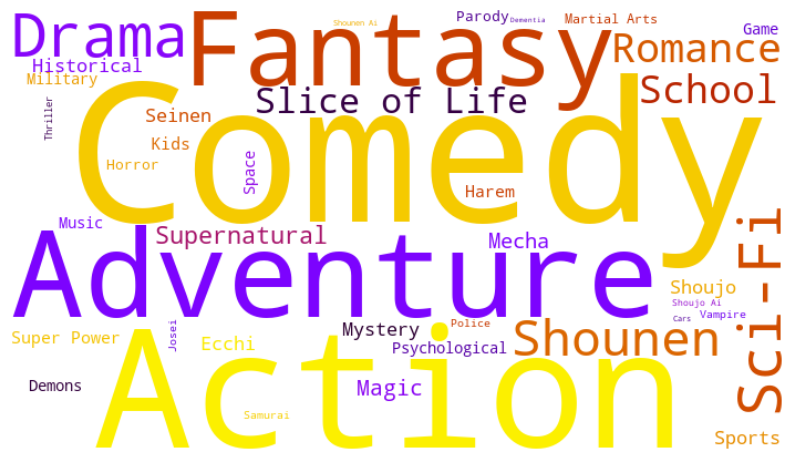

['Action',
 ' Military',
 ' Adventure',
 ' Comedy',
 ' Drama',
 ' Magic',
 ' Fantasy',
 ' Shounen',
 'Action',
 ' Military',
 ' Mystery',
 ' Super Power',
 ' Drama',
 ' Fantasy',
 ' Shounen',
 'Thriller',
 ' Sci-Fi',
 'Action',
 ' Drama',
 ' Fantasy',
 ' Military',
 ' Mystery',
 ' Shounen',
 ' Super Power',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Action',
 ' Adventure',
 ' Fantasy',
 ' Shounen',
 ' Super Power',
 'Action',
 ' Sci-Fi',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Shounen',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Drama',
 ' Game',
 ' Seinen',
 ' Slice of Life',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Slice of Life',
 ' Comedy',
 ' Supernatural',
 ' Drama',
 ' Romance',
 'Action',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 ' Shounen',
 'Mystery',
 ' Comedy',
 ' Supernatural',
 ' Vampire',

In [292]:
getFavGenre(df,plot=True)

In [293]:
def get_user_preferences(user_id,rating_df,df,verbose = 0,plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    animes_watched_by_user = animes_watched_by_user.dropna(subset=['rating'])
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = animes_watched_by_user.sort_values(by='rating', ascending=False).anime_id.values
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    if plot: getFavGenre(anime_df_rows,plot)
    return anime_df_rows[["anime_name", "genres"]]


In [294]:
df

,anime_id,anime_name,score,genres,episodes,type,premiered,members,genre_list
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456,"[Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen]"
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260,"[Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen]"
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162,"[Thriller, Sci-Fi]"
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626,"[Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power]"
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121,"[Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen]"
...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354,"[Adventure, Mystery, Supernatural]"
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010,"[Comedy, Horror, Supernatural]"
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",NaN,TV,Summer 2021,11309,"[Mystery, Dementia, Horror, Psychological, Supernatural, Thriller]"
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386,"[Adventure, Slice of Life, Comedy]"


In [295]:
rating_df

,user_id,anime_id,rating,user,anime
0,103819,6682,0.8,7654,1
1,67089,27603,0.6,4967,1460
2,161564,39701,0.5,11917,2393
3,182969,6547,0.8,13512,21
4,218472,7711,0.8,16190,891
...,...,...,...,...,...
14608234,23485,1569,0.7,1735,3557
14608235,39829,144,0.3,2956,1817
14608236,94450,13663,0.8,6934,644
14608237,53081,37377,0.5,3936,3623


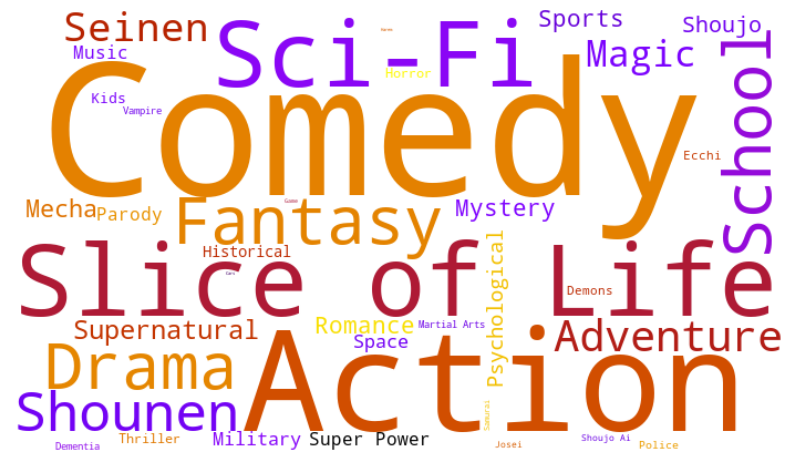

,anime_name,genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
9886,A Silent Voice,"Drama, School, Shounen"
11308,Your Name.,"Romance, Supernatural, School, Drama"
11624,Haikyu!! 3rd Season,"Comedy, Sports, Drama, School, Shounen"
...,...,...
16325,Templex,Dementia
16327,Out of My Mind,Dementia
16753,Soukyuu no Fafner: Dead Aggressor - The Beyond Part 3,"Action, Military, Sci-Fi, Drama, Mecha"
16847,Kanashimi no Kodomo-tachi,Music


In [296]:
get_user_preferences(10409,rating_df,df,plot=True)

In [297]:
def get_user_recommendations(similar_users, user_pref, df, syn_df, rating_df, n=10):
    anime_list = []
    
    for user_id in similar_users.similar_user.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[~pref_list.anime_name.isin(user_pref.anime_name.values)]
        if not pref_list.empty:
            anime_list.extend(pref_list.anime_name.values)
    if not anime_list:
        return pd.DataFrame()
    
    anime_counts = pd.Series(anime_list).value_counts().head(n)
    recommendations = [
        {
            "n": count,
            "anime_name": anime_name,
            "genres": (frame := getAnimeFrame(anime_name, df)).genres.values[0]
        }
        for anime_name, count in anime_counts.items()
        if isinstance(anime_name, str)
    ]
    return pd.DataFrame(recommendations)

In [298]:
similar_users = find_similar_users(10409,user_weights,user2user_encoder,user2user_decoder)

In [299]:
user_pref = get_user_preferences(10409 , rating_df, df , plot=False)

In [300]:
rating_df

,user_id,anime_id,rating,user,anime
0,103819,6682,0.8,7654,1
1,67089,27603,0.6,4967,1460
2,161564,39701,0.5,11917,2393
3,182969,6547,0.8,13512,21
4,218472,7711,0.8,16190,891
...,...,...,...,...,...
14608234,23485,1569,0.7,1735,3557
14608235,39829,144,0.3,2956,1817
14608236,94450,13663,0.8,6934,644
14608237,53081,37377,0.5,3936,3623


In [301]:
similar_users

,similar_user,similarity
0,87534,0.766311
1,155858,0.720396
2,52773,0.702317
3,216100,0.697969
4,200422,0.694230
5,142117,0.690564
6,144144,0.686241
7,79750,0.683544
8,156480,0.682247
9,47090,0.679901


In [302]:
get_user_recommendations(similar_users,user_pref,df, syn_df,rating_df,n=5)

,n,anime_name,genres
0,10,Bakemonogatari,"Romance, Supernatural, Mystery, Vampire"
1,9,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
2,9,Clannad,"Comedy, Drama, Romance, School, Slice of Life, Supernatural"
3,9,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"
4,8,Toradora!,"Slice of Life, Comedy, Romance, School"


In [303]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    similar_users = find_similar_users(user_id, user_weights, user2user_encoder, user2user_decoder)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, syn_df, rating_df)
    user_list = user_recommended_animes["anime_name"].tolist()
    
    content_list = [
        similar_anime
        for anime in user_list
        for similar_animes in [find_similar_animes(anime, anime_weights, anime2anime_encoder, anime2anime_decoder, df, syn_df)]
        if similar_animes is not None and not similar_animes.empty
        for similar_anime in similar_animes["name"].tolist()
    ]
    
    from collections import Counter
    combined_scores = Counter({anime: user_weight for anime in user_list})
    combined_scores.update({anime: content_weight for anime in content_list})
    return combined_scores.most_common(10)

In [304]:
def create_temp_user_profile(anime_ratings_dict, df):
    temp_profile = []
    for anime_name, rating in anime_ratings_dict.items():
        anime_frame = getAnimeFrame(anime_name, df)
        if not anime_frame.empty:
            anime_id = anime_frame.anime_id.values[0]
            temp_profile.append({
                'user_id': -1, 
                'anime_id': anime_id,
                'anime_name': anime_name,
                'rating': rating
            })
    
    return pd.DataFrame(temp_profile)


In [305]:
def build_user_inf_model(recomm_model, embedding_size=32):
    
    user_vec = Input(shape=(embedding_size,), name='user_vec')
    anime = Input(shape=(1,), name='anime')
    
    anime_emb = recomm_model.get_layer('anime_embedding')(anime)
    anime_vec = Flatten(name='flatten_anime')(anime_emb)
    
    x = Concatenate(name='concat')([user_vec, anime_vec])
    
    x = recomm_model.get_layer('dense')(x)
    x = recomm_model.get_layer('batch_normalization')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = recomm_model.get_layer('dense_1')(x)
    x = recomm_model.get_layer('batch_normalization_1')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = recomm_model.get_layer('dense_2')(x)
    
    inf_model = Model(inputs=[user_vec, anime], outputs=x)
    return inf_model

In [331]:
def get_temp_user_embedding(temp_user_profile, inf_model, anime2anime_encoder, embedding_size=32, min_rating=None, max_rating=None, epochs=50, lr=0.01):
    import tensorflow as tf
    import numpy as np
    
    anime_list = []
    rating_list = []
    for _, row in temp_user_profile.iterrows():
        anime_id = row['anime_id']
        encoded_anime = anime2anime_encoder.get(anime_id)
        if encoded_anime is not None:
            anime_list.append(encoded_anime)
            normalized_rating = (row['rating'] - min_rating) / (max_rating - min_rating) if min_rating is not None and max_rating is not None else row['rating'] / 10.0
            rating_list.append(normalized_rating)
    
    if not anime_list:
        return np.zeros(embedding_size)
    
    anime_indices = tf.constant(anime_list, dtype=tf.int32)[:, tf.newaxis] 
    targets = tf.constant(rating_list, dtype=tf.float32)
    
    user_emb_var = tf.Variable(tf.random.normal([embedding_size], stddev=0.05))
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            user_vec_input = tf.tile(user_emb_var[tf.newaxis, :], [len(anime_list), 1])
            preds = inf_model([user_vec_input, anime_indices])
            preds = tf.squeeze(preds)
            loss = loss_fn(targets, preds)
        grads = tape.gradient(loss, [user_emb_var])
        optimizer.apply_gradients(zip(grads, [user_emb_var]))
    
    temp_emb = user_emb_var.numpy()
    norm = np.linalg.norm(temp_emb)
    return temp_emb / norm if norm > 0 else temp_emb

In [332]:
def find_similar_users_for_temp(temp_embedding, user_weights, user2user_decoder, n=10):
    import numpy as np
    if np.all(temp_embedding == 0):
        print("Warning: Temp user embedding is zero; returning empty user list.")
        return pd.DataFrame(columns=['similar_user', 'similarity'])
    similarities = np.dot(user_weights, temp_embedding)
    nan_mask = np.isnan(similarities)
    valid_indices = np.where(~nan_mask)[0]
    valid_sorted = valid_indices[np.argsort(similarities[valid_indices])[::-1]]
    similar_users_data = []
    for i, user_idx in enumerate(valid_sorted[:n]):
        user_id = user2user_decoder.get(user_idx)
        similarity = similarities[user_idx]
        similar_users_data.append({
            'similar_user': user_id,
            'similarity': similarity
        })
    return pd.DataFrame(similar_users_data)

In [333]:
def hybrid_recommendation_for_temp_user(temp_similar_users, temp_user_profile, user_weight=0.5, content_weight=0.5):
    user_recommended_animes = get_user_recommendations(temp_similar_users, temp_user_profile, df, syn_df, rating_df)
    user_list = user_recommended_animes["anime_name"].tolist()
    
    content_list = [
        similar_anime
        for anime in user_list
        for similar_animes in [find_similar_animes(anime, anime_weights, anime2anime_encoder, anime2anime_decoder, df, syn_df)]
        if similar_animes is not None and not similar_animes.empty
        for similar_anime in similar_animes["name"].tolist()
    ]
    
    from collections import Counter
    combined_scores = Counter({anime: user_weight for anime in user_list})
    combined_scores.update({anime: content_weight for anime in content_list})
    return combined_scores.most_common(20)




In [342]:
def recommend_for_temp_user(anime_ratings_dict, n_recommendations=10, user_weight=0.5, content_weight=0.5):
    temp_user_profile = create_temp_user_profile(anime_ratings_dict, df)
    inf_model = build_user_inf_model(recomm_model)
    temp_embedding = get_temp_user_embedding(temp_user_profile, inf_model,anime2anime_encoder, min_rating=min_rating, max_rating=max_rating)
    similar_users = find_similar_users_for_temp(temp_embedding, user_weights, user2user_decoder, n=10)
    hybrid_results = hybrid_recommendation_for_temp_user(similar_users, temp_user_profile, user_weight, content_weight)
    
    if not hybrid_results:
        return "Sorry, Couldn't find any anime matching with you!"
    
    max_score = hybrid_results[0][1] if hybrid_results else 1
    
    final_recommendations = []
    for anime_name, score in hybrid_results[:n_recommendations]:
        anime_frame = getAnimeFrame(anime_name, df)
        if not anime_frame.empty:
            probability = min((score / max_score) * 0.8, 0.8)
            final_recommendations.append({
                'anime_name': anime_name,
                'genres': anime_frame.genres.values[0],
                'hybrid_score': score,
                'probability': probability
            })
    return pd.DataFrame(final_recommendations)

In [343]:
user_ratings = {
    'Attack on Titan': 9,
    'Death Note': 8,
    'One Piece': 1,
    'Naruto': 6,
    'Monster' : 2
}

In [344]:
recommendations = recommend_for_temp_user(user_ratings,user_weight=0.5,content_weight=0.5)

In [347]:
recommendations['anime_name']

0                                                     Bakuman.
1                                                 Aldnoah.Zero
2                                                    Fate/Zero
3                      Fate/stay night [Unlimited Blade Works]
4                            The Testament of Sister New Devil
5                                                 Angel Beats!
6                                                  Steins;Gate
7    the Garden of sinners Chapter 2:Murder Speculation Part A
8                                                    Toradora!
9                                             Sword Art Online
Name: anime_name, dtype: object

In [346]:
recomm_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │    561,536 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 32)     │    548,480 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ activation_22[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 64)        │          0 │ activation_23[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,127,425 (4.30 MB)

 Trainable params: 1,127,041 (4.30 MB)

 Non-trainable params: 384 (1.50 KB)